In [7]:
# Import nessesary libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
import itertools
from tqdm import tqdm

# NLP libraries
from nltk.corpus import stopwords
#from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import bigrams as nltkbigrams
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from gensim.models.tfidfmodel import TfidfModel
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

# Visualisation libraries
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import networkx as nx
import pyLDAvis
import pyLDAvis.gensim

In [175]:
# Import English language reviews
df = pd.read_csv('input/english_reviews_v2.csv')
df = df.drop(['text', 'helpfulVotes', 'createdDate'], axis = 1)
df = df.rename(columns={"text_n": "text"})
df.head()

,stayDate,hotelName,rating,tripType,parentGeo,text
0,2020-02-29,Hana Riverside Villa,4,NONE,Quảng Ngãi,Hana Riverside Quang Ngai hotel Located in a q...
1,2020-02-29,Hana Riverside Villa,5,SOLO,Quảng Ngãi,Dropped in here for 1 night on my way north. F...
2,2019-09-30,Hana Riverside Villa,4,COUPLES,Quảng Ngãi,Stayed here for one night while passing throug...
3,2018-09-30,Hana Riverside Villa,5,COUPLES,Quảng Ngãi,Kind Of difficult to find but we had a great s...
4,2020-03-31,Cocoland River Beach Resort & Spa,1,COUPLES,Quảng Ngãi,Do not go to this place. The manager is a liar...


## Preprocessing

In [176]:
# import stopwords
stop_words = stopwords.words('english')

# Add addional stop words
stop_words = stop_words + ['etc']

# Remove words for negation from the stop words list
words_to_remove = ['no', 'not', 'very']
for word in words_to_remove:
    try:
        stop_words.remove(word)
    except:
        print("Word '"+ word + "' not in the list")


wnl = WordNetLemmatizer()

# Preprocessing of Reviews

all_tokens = []
all_nouns = []
all_verbs = []
all_adj = []

for review in df['text']:
    # Convert a document into a list of tokens
    # This lowercases, tokenizes, removes numerical values
    tokens = simple_preprocess(review)

    # Apply POS tagging
    pos_tags = pos_tag(tokens)

    doc_out = []
    nouns = []
    verbs = []
    adjs = []

    for word, tag in pos_tags:
        if word not in stop_words:
            # Check if the word is a verb
            if tag.startswith('V'):
                # Lemmatize the verb (get base form)
                lemma = WordNetLemmatizer().lemmatize(word, pos='v')
                doc_out.append(lemma)
                verbs.append(lemma)
            elif tag.startswith('N'):
                # Lemmatize the verb (get base form)
                lemma = WordNetLemmatizer().lemmatize(word, pos='n')
                doc_out.append(lemma)
                nouns.append(lemma)
            elif tag.startswith('J'):
                # Lemmatize the verb (get base form)
                lemma = WordNetLemmatizer().lemmatize(word, pos='a')
                doc_out.append(lemma)
                adjs.append(lemma)
            elif tag.startswith('R'):
                # Lemmatize the verb (get base form)
                lemma = WordNetLemmatizer().lemmatize(word, pos='r')
                doc_out.append(lemma)
            else:
                doc_out.append(word)  # Keep the rest of tokens as is

    all_tokens.append(doc_out)
    all_nouns.append(nouns)
    all_verbs.append(verbs)
    all_adj.append(adjs)

# Add tokens columns to the dataframe
df['Tokens'] = all_tokens
df['nouns'] = all_nouns
df['verbs'] = all_verbs
df['adj'] = all_adj

# Print out infromation about articles and number of tokens for top 15
print('Tokens groups created:', len(all_tokens),'\n')
df[['Tokens', 'nouns', 'verbs', 'adj']].head()

Tokens groups created: 32449 



,Tokens,nouns,verbs,adj
0,"[hana, riverside, quang, ngai, hotel, locate, ...","[hana, hotel, villa, area, river, km, city, ce...","[riverside, locate, sleep, bark]","[quang, ngai, quiet, cool, clean, spacious, fr..."
1,"[drop, night, way, north, friendly, helpful, s...","[night, way, staff, room, seafood, street, dis...","[drop, locate, walk, recommend]","[north, helpful, clean, spacious, great]"
2,"[stay, one, night, pass, room, clean, tidy, ke...","[night, room, tidy, kettle, fridge, bathroom, ...","[stay, pass, find, get, wake, bark, allow, con...","[clean, good, nice, clean, modern, best, stand..."
3,"[kind, difficult, find, great, stay, place, qu...","[kind, place, city, food, staff, place, city]","[find, stay, buy, motorbike]","[difficult, great, ok, nice, great]"
4,"[not, go, place, manager, liar, first, receive...","[place, manager, rate, night, com, anything, s...","[go, receive, demonstrate, book, check, believ...","[liar, expensive, honest, expensive, overrated..."


In [97]:
print(df['Tokens'][2])

['stay', 'one', 'night', 'pass', 'room', 'clean', 'tidy', 'kettle', 'fridge', 'good', 'nice', 'clean', 'modern', 'bathroom', 'not', 'best', 'location', 'us', 'find', 'something', 'dinner', 'anything', 'standard', 'local', 'food', 'bed', 'comfy', 'main', 'issue', 'get', 'repeatedly', 'wake', 'night', 'dog', 'bark', 'very', 'close', 'allow', 'continue', 'bark', 'night', 'early', 'hour', 'morning', 'very', 'frustrating', 'not', 'problem', 'no', 'issue', 'accommodation']


# Dictionary and Corpous

In [177]:
# Create dictionary - a map of unique tokens
dictionary = Dictionary(df.Tokens)
# Filter dictionary for extremes - experiment with this values
dictionary.filter_extremes(no_below = 20, no_above = 0.8)
print('Dictionary length:', len(dictionary.keys()))

# 100 tokens by frequency for cleaned up dictionary
t_most_freq = dictionary.most_common(100)

# Print top 20 tokens
print('Top 20 tokens by frequency\n')
num = 1
for t, f in t_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(token) for token in df.Tokens]
print('\nCorpus created. \nCorpus length:', len(corpus))

Dictionary length: 4924
Top 20 tokens by frequency

1. not - 39356
2. very - 34396
3. stay - 32094
4. room - 29278
5. staff - 26090
6. resort - 24679
7. hotel - 23509
8. good - 20924
9. us - 19787
10. food - 19103
11. great - 18962
12. pool - 18095
13. place - 17408
14. beach - 16726
15. day - 15713
16. one - 15360
17. night - 15122
18. would - 14804
19. service - 14652
20. villa - 14442

Corpus created. 
Corpus length: 32449


In [107]:
# Writing top 500 tokens for all reviews by frequency to a CSV file
top_df = pd.DataFrame(dictionary.most_common(500))
top_df.columns = ['token', 'frequency']
top_df.to_csv('output/viet_frequency_top_500.csv', index = False, header = True)

In [178]:
# Top 20 tokens by frequency for all reviews
words = []
freqs = []
for num in range(0, 20):
    word, freq = dictionary.most_common(20)[num]
    words.append(word)
    freqs.append(freq)

data = pd.DataFrame({'words': words, 'freqs': freqs})

# Bar chart for the frequences
fig = px.bar(data, x='freqs', y='words', title="Top-20 words by frequency",
            width=700, height=500)
fig.update_xaxes(title = 'Frequency')
fig.update_yaxes(title = 'Tokens', autorange="reversed")
fig.show()

/opt/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Nouns only

In [182]:
# create dictionary for nouns only - a map of unique tokens
dictionary_noun = Dictionary(df.nouns)
# Filter dictionary for extremes - experiment with this values
dictionary_noun.filter_extremes(no_below = 20, no_above = 0.8)
print('Dictionary length:', len(dictionary_noun.keys()))

# 100 tokens by frequency for cleaned up dictionary
noun_most_freq = dictionary_noun.most_common(100)
# Print info about top 20 tokens
print('Top 20 tokens by frequency\n')
num = 1
for t, f in noun_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

Dictionary length: 2918
Top 20 tokens by frequency

1. room - 29273
2. staff - 26029
3. resort - 24175
4. hotel - 23298
5. food - 19103
6. pool - 17270
7. place - 16992
8. beach - 15786
9. day - 15713
10. night - 15122
11. service - 14463
12. villa - 14003
13. time - 13919
14. restaurant - 11796
15. stay - 10862
16. breakfast - 10514
17. view - 8281
18. family - 7979
19. area - 7904
20. trip - 6749


In [109]:
# Writing top 250 nouns for all reviews by frequency to a CSV file
top_df = pd.DataFrame(dictionary_noun.most_common(250))
top_df.columns = ['token', 'frequency']
top_df.to_csv('output/viet_frequency_top_250_nouns.csv', index = False, header = True)

In [183]:
# Top 20 nouns by frequency for all reviews
words = []
freqs = []
for num in range(0, 20):
    word, freq = dictionary_noun.most_common(20)[num]
    words.append(word)
    freqs.append(freq)

data = pd.DataFrame({'words': words, 'freqs': freqs})

# Bar chart for the frequences
fig = px.bar(data, x='freqs', y='words', title="Top-20 nouns by frequency",
            width=700, height=500)
fig.update_xaxes(title = 'Frequency')
fig.update_yaxes(title = 'Tokens', autorange="reversed")
fig.show()

/opt/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Noun word cloud

In [166]:
# Combine all noun tokens into one text
noun_text = ''
for nouns in df['nouns']:
    if len(nouns)> 0:
        noun_string = " ".join(nouns)
        noun_text = noun_text + ' ' + noun_string
noun_text[:1000]

' hana hotel villa area river km city center room staff destination tourist hotel construction railing night dog door night way staff room seafood street distance couple night night room tidy kettle fridge bathroom location something dinner anything food bed issue night dog night hour morning problem issue accommodation kind place city food staff place city place manager rate night com anything someone person option bungalow price price site day price site desk guy reception price price hello manager phone bla bla ok advice penny middle nothing view pool bungalow food service tranquil resort staff kind value money brilliant spa massage range oil experience relaxing calm quality pool time life guard treat service facility environment especialy spa skill stay night resort escape beautiful garden room garden outlook crystal swimming staff sure speciality food hospitality accomodation night guest house price reason second welcoming owner couple everything problem communicating bed cover fa

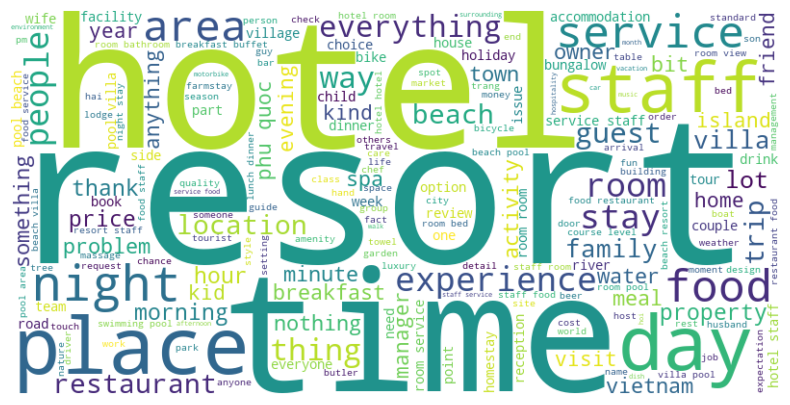

In [179]:
# Word cloud for nouns
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(noun_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Adjectives only

In [184]:
# create dictionary for nouns only - a map of unique tokens
dictionary_adj = Dictionary(df.adj)
# Filter dictionary for extremes - experiment with this values
dictionary_adj.filter_extremes(no_below = 20, no_above = 0.8)
print('Dictionary length:', len(dictionary_adj.keys()))

# 100 tokens by frequency for cleaned up dictionary
adj_most_freq = dictionary_adj.most_common(100)
# Print info about top 20 tokens
print('Top 20 tokens by frequency\n')
num = 1
for t, f in adj_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

Dictionary length: 1422
Top 20 tokens by frequency

1. good - 20750
2. great - 18959
3. nice - 13111
4. beautiful - 9617
5. friendly - 9104
6. clean - 7836
7. best - 7356
8. helpful - 5972
9. private - 5612
10. excellent - 5482
11. wonderful - 5140
12. many - 5054
13. comfortable - 4817
14. local - 4754
15. little - 4721
16. big - 4720
17. free - 4703
18. perfect - 4592
19. much - 4574
20. amazing - 4469


In [112]:
# Writing top 250 nouns for all reviews by frequency to a CSV file
top_df = pd.DataFrame(dictionary_adj.most_common(250))
top_df.columns = ['token', 'frequency']
top_df.to_csv('output/viet_frequency_top_250_adj.csv', index = False, header = True)

In [185]:
# Top 20 tokens by frequency for all answers
words = []
freqs = []
for num in range(0, 20):
    word, freq = dictionary_adj.most_common(20)[num]
    words.append(word)
    freqs.append(freq)

data = pd.DataFrame({'words': words, 'freqs': freqs})

# Bar chart for the frequences
fig = px.bar(data, x='freqs', y='words', title="Top-20 adjectives by frequency",
            width=700, height=500)
fig.update_xaxes(title = 'Frequency')
fig.update_yaxes(title = 'Tokens', autorange="reversed")
fig.show()

/opt/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Adjective word cloud

In [181]:
# Combine all adjective tokens into one text
adj_text = ''
for words in df['adj']:
    if len(words)> 0:
        adj_string = " ".join(words)
        adj_text = adj_text + ' ' + adj_string
adj_text[:1000]

' quang ngai quiet cool clean spacious friendly favorite outside dusty next north helpful clean spacious great clean good nice clean modern best standard local comfy main early frustrating difficult great ok nice great liar expensive honest expensive overrated bla worth cool comfortable beautiful attentful good clean full spacious amazing full real excellent excellent excellent excellent excellent enjoyed new perfect private clear local cheap good first clean lovely willing english good hot shower comfy ac nice friendly expensive good good nice autentic sweet cheerful generous eager spacious comfortable pretty cheap nice english best big fresh comfortable clean great friendly warmly real clean cheap open comfortable best best free secure best happy nice sure best sweet happy able free welcome full lovely true cannot beautiful welcome big kind helpful much english sign speak much fluent english great clean good perfect clean best free great secure mechanic bad clean big great free engli

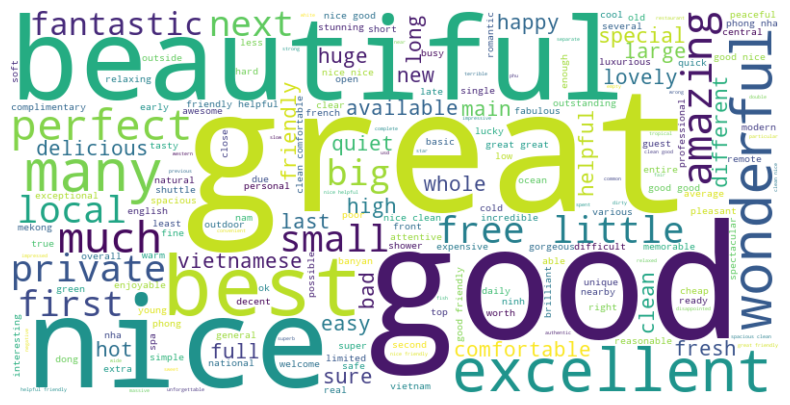

In [180]:
# Word cloud for adjectives
adjcloud = WordCloud(width=800, height=400, background_color='white').generate(adj_text)
plt.figure(figsize=(10, 5))
plt.imshow(adjcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Bigrams

In [186]:
bigrams = [list(nltkbigrams(review)) for review in df.Tokens]

# Flatten list of bigrams
bigrams_list = list(itertools.chain(*bigrams))

# Create counter of words in bigrams list
bigram_counts = Counter(bigrams_list)
print('Number of unique bigrams in the answers:', len(bigram_counts))

bigram_df = pd.DataFrame(bigram_counts.most_common(500), columns=['bigram', 'count'])

bigram_df.head(20)

Number of unique bigrams in the answers: 806606


,bigram,count
0,"(very, good)",3209
1,"(come, back)",3133
2,"(highly, recommend)",2839
3,"(staff, very)",2720
4,"(very, nice)",2681
5,"(could, not)",2600
6,"(phu, quoc)",2481
7,"(very, friendly)",2426
8,"(phong, nha)",2155
9,"(stay, night)",1887


In [116]:
# EXporting top 300 bigrams to CSV
bigram_df[:300].to_csv('output/viet_bigrams_top_300.csv', index = False, header = True)

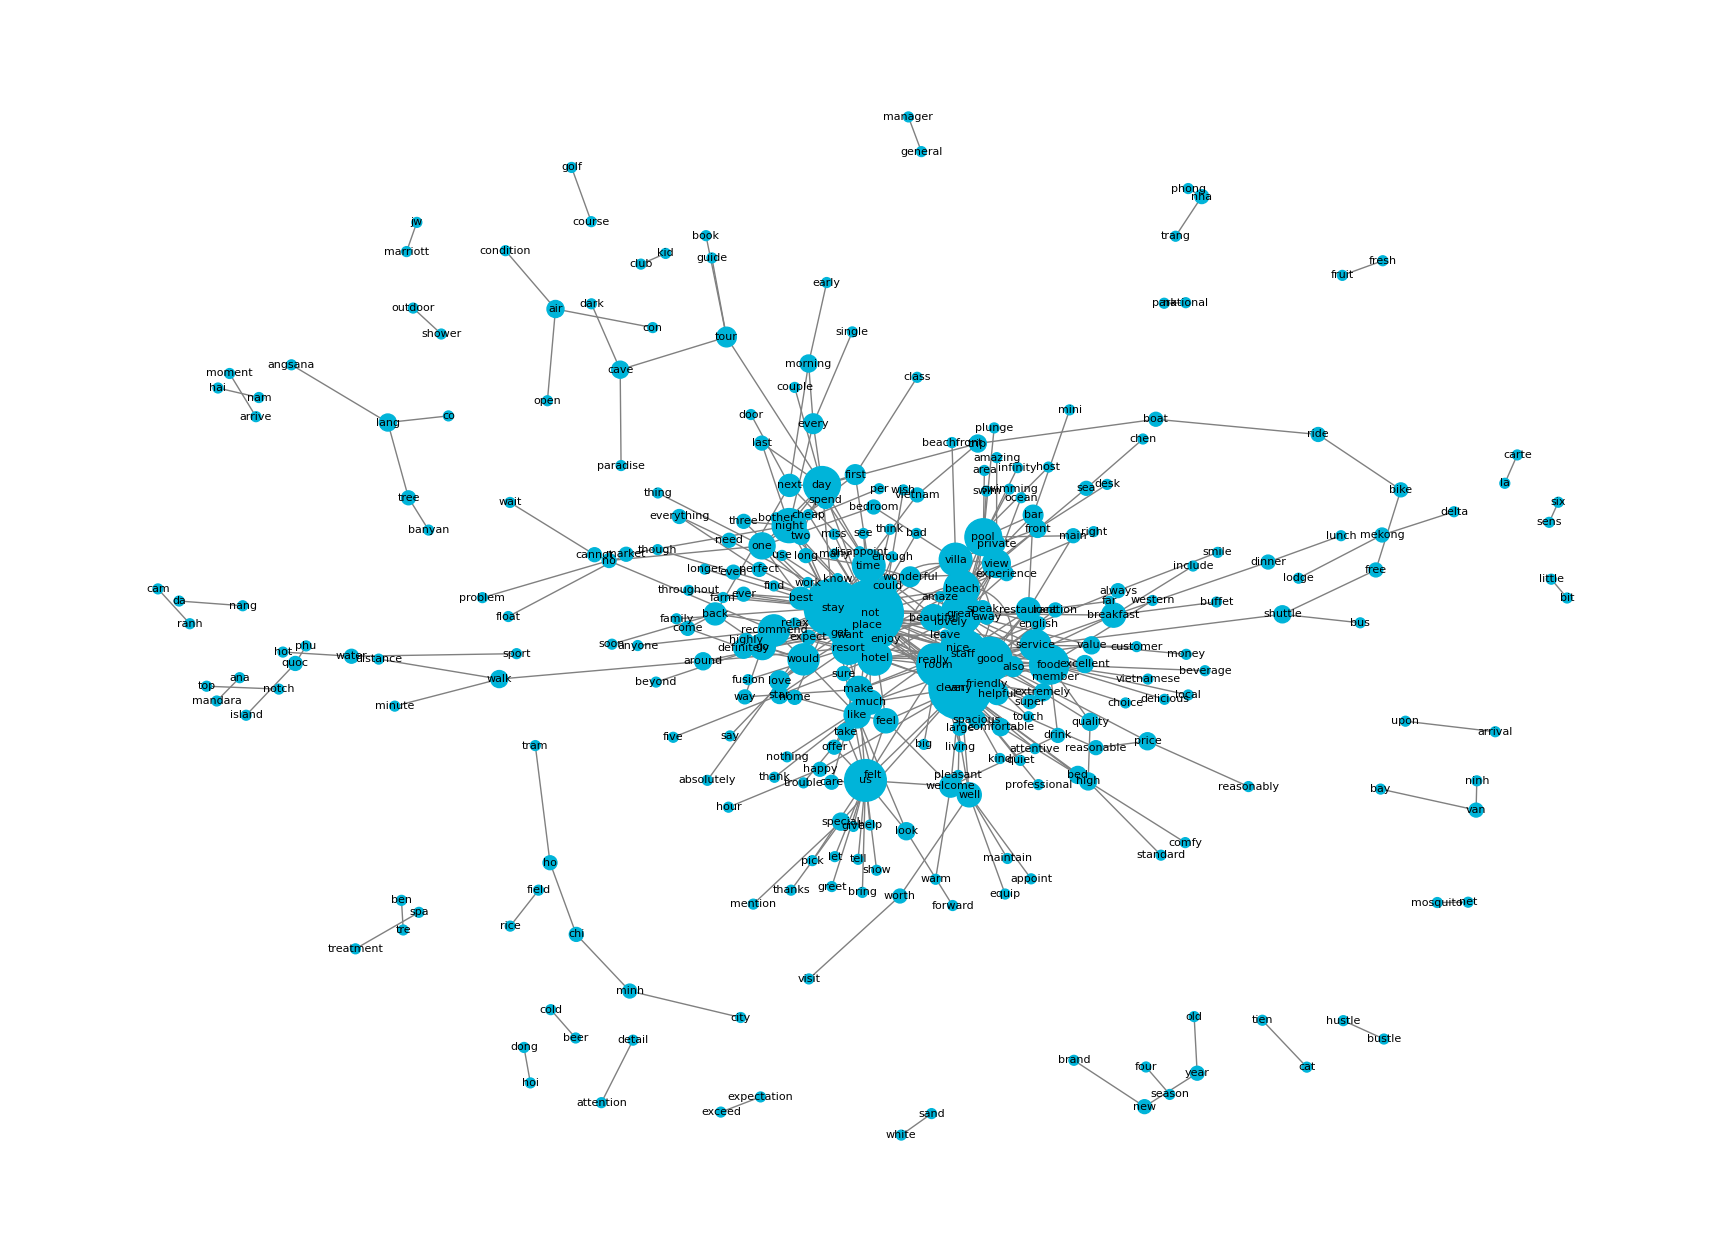

In [187]:
# Bigram visualisation for top 500 bigrams
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = bigram_df[:500].set_index('bigram').T.to_dict('records')

# Create network plot
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

# Use node degree as the node size

fig, ax = plt.subplots(figsize=(22, 16))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size=8,
        width=1,
        edge_color='grey',
        node_color='#00b4d9',
        with_labels = True,
        #nodelist=d.keys(),
        node_size=[v * 50 for v in d.values()])
plt.show()

In [188]:
# https://github.com/oliviatan29/network_analysis/tree/main
# Define get_nodes_and_nbrs()
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
    return G.subgraph(nodes_to_draw)

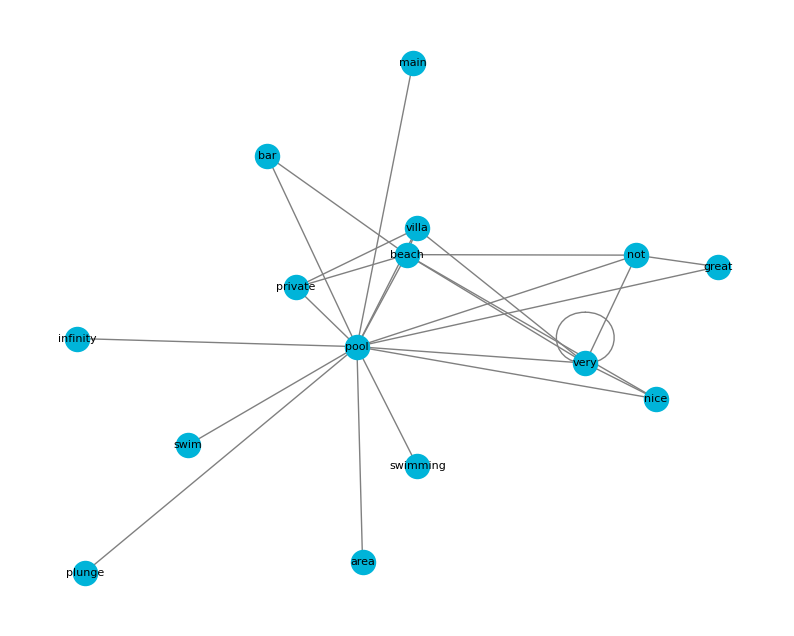

In [189]:
fig, ax = plt.subplots(figsize=(10, 8))

# Extract the subgraph with the nodes of interest: T_draw
T_draw = get_nodes_and_nbrs(G, ['pool'])

# Draw the subgraph to the screen
nx.draw(T_draw, with_labels=True, font_size=8,
        width=1,
        edge_color='grey',
        node_color='#00b4d9',)
plt.show()

# Trigrams

In [190]:
# Train a toy phrase model on corpus
phrase_model = Phrases(df.Tokens, min_count = 2, threshold = 1, connector_words = ENGLISH_CONNECTOR_WORDS)

# Train trigram model on all tockens
trigram  = Phrases(phrase_model[df.Tokens], min_count = 10)

# Create a list of all trigrams
trigram_list = []
for token in df.Tokens:
    trigrams_ = [t for t in trigram[phrase_model[token]] if t.count('_')==2]
    if len(trigrams_) > 0:
        trigram_list.append(trigrams_)

print('Total number of answers with trigrams:', len(trigram_list))

# create dictionary of trigrams
trigram_dic = Dictionary(trigram_list)
print('Number of unique trigrams:', len(trigram_dic.keys()))

# Top 100 tigrams by frequency in all articles
trigram_most_freq = trigram_dic.most_common(100)
print('\nTop 20 trigrams by frequency\n')

num = 1
for t, f in trigram_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

Total number of answers with trigrams: 18336
Number of unique trigrams: 1038

Top 20 trigrams by frequency

1. staff_very_friendly - 445
2. stay_one_night - 353
3. definitely_come_back - 297
4. staff_friendly_helpful - 290
5. would_highly_recommend - 278
6. food_very_good - 265
7. stay_two_night - 261
8. nothing_much_trouble - 237
9. not_want_leave - 222
10. staff_very_helpful - 189
11. phu_quoc_island - 179
12. great_place_stay - 174
13. ho_chi_minh - 172
14. really_enjoy_stay - 171
15. beach_front_villa - 162
16. villa_private_pool - 155
17. take_care_us - 154
18. phong_nha_farmstay - 153
19. would_definitely_recommend - 152
20. angsana_lang_co - 148


In [34]:
# Explort top 100 trigrams to CSV
trigram_df = pd.DataFrame(trigram_most_freq, columns=['trigram', 'count'])
trigram_df.to_csv('output/viet_trigram_top_100_.csv', index = False, header = True)

# LDA model

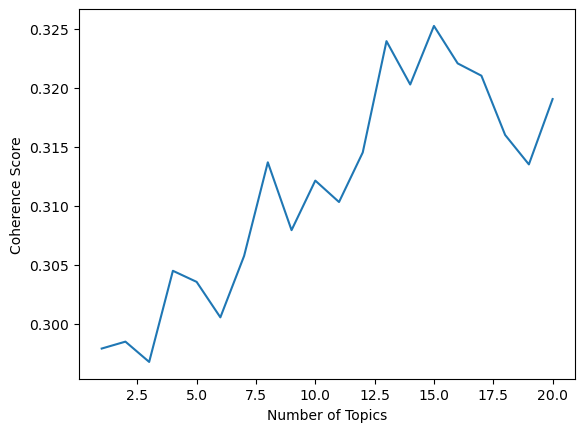

In [195]:
# Finding best number of topics for LDA based on c_v coherence score (Best coherence for c_v is typically the maximum)
topics = []
score = []
for i in tqdm(range(1,21,1)):
    lda_model = LdaMulticore(corpus = corpus, id2word = dictionary,
                             iterations = 10, num_topics = i,
                             workers = 3, passes = 5,
                             random_state = 100)
    cm = CoherenceModel(model = lda_model, dictionary = dictionary,
                        coherence='c_v', texts = df.Tokens)
    topics.append(i)
    score.append(cm.get_coherence())

_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [205]:
# Coherence score by number of topics
topics_data = {'topic_number':topics, 'coherence_score': score}
topics_df = pd.DataFrame(topics_data)
topics_df = topics_df.set_index('topic_number')
topics_df

,coherence_score
topic_number,
1,0.297890
2,0.298476
3,0.296756
4,0.304482
5,0.303543
6,0.300535
7,0.305741
8,0.313680
9,0.307929


In [203]:
# Train our lda model
lda_model = LdaMulticore(corpus = corpus, id2word = dictionary,
                         iterations = 100, num_topics = 13,
                         workers = 4, passes = 5,
                         random_state = 100)

cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary,
                        coherence='u_mass')
cm_score = cm.get_coherence()

print('LDA model u_mass coherence score:', cm_score)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))

LDA model coherence score: -1.3083805155289765

Topic: 0 
Words: 0.022*"stay" + 0.019*"staff" + 0.018*"us" + 0.018*"make" + 0.012*"service" + 0.011*"very" + 0.011*"great" + 0.009*"time" + 0.009*"thank" + 0.008*"family"

Topic: 1 
Words: 0.030*"very" + 0.029*"room" + 0.016*"stay" + 0.013*"bed" + 0.011*"large" + 0.011*"pool" + 0.009*"shower" + 0.009*"comfortable" + 0.009*"area" + 0.008*"staff"

Topic: 2 
Words: 0.028*"stay" + 0.023*"place" + 0.021*"great" + 0.018*"very" + 0.017*"lake" + 0.015*"cave" + 0.014*"staff" + 0.014*"food" + 0.013*"phong" + 0.013*"nha"

Topic: 3 
Words: 0.041*"us" + 0.018*"cave" + 0.018*"day" + 0.017*"tour" + 0.014*"book" + 0.013*"not" + 0.012*"stay" + 0.012*"staff" + 0.009*"room" + 0.009*"trip"

Topic: 4 
Words: 0.041*"not" + 0.014*"room" + 0.013*"staff" + 0.011*"resort" + 0.011*"would" + 0.009*"very" + 0.009*"stay" + 0.009*"food" + 0.009*"get" + 0.008*"place"

Topic: 5 
Words: 0.028*"very" + 0.022*"resort" + 0.021*"staff" + 0.017*"stay" + 0.014*"nice" + 0.014*"g

## LDA Visualisation

In [204]:
#Creating Topic Distance Visualization
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.040359 -0.056305       1        1  15.161201
7      0.081774 -0.063448       2        1  13.846375
8     -0.010590 -0.076018       3        1  11.409420
0      0.103711  0.053318       4        1   9.925280
5      0.110423 -0.000757       5        1   7.823587
6     -0.066253  0.020397       6        1   7.622026
10    -0.040954 -0.018914       7        1   7.267416
12     0.034380  0.115890       8        1   6.381801
9     -0.161070 -0.032573       9        1   5.882777
2     -0.017948  0.085182      10        1   4.917153
11     0.079306 -0.092006      11        1   3.734861
1     -0.030613 -0.038989      12        1   3.272366
3     -0.041807  0.104221      13        1   2.755737, topic_info=      Term          Freq         Total Category  logprob  loglift
523  beach  15901.000000  15901.000000  Default  30.0000  30.0000
85      us  19802.000000  19802.000000  Default  29.0000  29.0000
29    room  29732.000000  29732.000000  Default  28.0000  28.0000
14   hotel  23255.000000  23255.000000  Default  27.0000  27.0000
34    very  35176.000000  35176.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
391  visit    349.695689   5865.308090  Topic13  -5.2515   0.7717
34    very    528.367869  35176.990294  Topic13  -4.8388  -0.6069
225  would    432.444021  14770.066762  Topic13  -5.0391   0.0606
65     get    406.410864  13430.965497  Topic13  -5.1012   0.0935
7    could    382.408100   8648.080779  Topic13  -5.1621   0.4729

[1072 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4214      1  0.873639    abit
4214      9  0.097071    abit
2457      2  0.060959  absorb
2457      5  0.060959  absorb
2457      6  0.853424  absorb
...     ...       ...     ...
2398      8  0.108190     yum
2398     10  0.476034     yum
3735      4  0.871959    zoom
3735      6  0.084383    zoom
3735     10  0.028128    zoom

[5966 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 9, 1, 6, 7, 11, 13, 10, 3, 12, 2, 4])

In [ ]:
# save model to disk (no need to use pickle module)
lda_model.save('output/viet_lda_model.model')